# Проект для "Ниединогоразрыва.ком"

**Описание проекта:** Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание данных:** Данные состоят из файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Цель проекта:** Построить модель машинного обучения для прогнозирования оттока клиентов.

**План проекта:**

1. Подготовка данных
  - Открытие файла
  - Предобработка данных
2. Исследовательский анализ данных
3. Обучение моделей
  - Подготовка признаков
  - Обучение моделей при помощи кросс-валидации
4. Тестирование лучшей модели на тестовой выборке
5. Вывод по проекту

## Подготовка данных

In [1]:
!pip install catboost
!pip install lightgbm
!pip install phik

In [2]:
import pandas as pd
import warnings
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score
from phik import phik_matrix
import time
from sklearn.metrics import roc_curve

In [3]:
display(HTML("<style>.container { width:85% !important; }</style>"))
warnings.filterwarnings("ignore")
try:# конструкция try - except для надёжности
    df_contract = pd.read_csv('contract_new.csv')
    df_personal = pd.read_csv('personal_new.csv')
    df_internet = pd.read_csv('internet_new.csv')
    df_phone = pd.read_csv('phone_new.csv')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')

In [4]:
def inf(data):#функция для вывода информации о датасете
    data.info()
    display(data.describe(include='all').T)
    display(data.corr())
    print('-------------------------------------')
    print('Дубликатов:', data.duplicated().sum())
    return display(data.head())

In [5]:
for i in [df_contract, df_personal, df_internet, df_phone]:
    inf(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,MonthlyCharges
MonthlyCharges,1.0


-------------------------------------
Дубликатов: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,SeniorCitizen
SeniorCitizen,1.0


-------------------------------------
Дубликатов: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


""


-------------------------------------
Дубликатов: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


""


-------------------------------------
Дубликатов: 0


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Промежуточный вывод:** В некоторых столбцах надо поменять тип данных на datetime, пропусков и дубликатов нету.

In [6]:
df_contract['target'] = df_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)#добавляю таргет в датасет 

In [7]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [8]:
df_internet['internet'] = 1
df_phone['phone'] = 1#добавляю эти столбцы, чтобы понимать чем пользуется каждый клиент

In [9]:
df = pd.merge(df_contract, df_personal, on='customerID', how='outer')
df = pd.merge(df, df_internet, on='customerID', how='outer')
df = pd.merge(df, df_phone, on='customerID', how='outer')#объединяю все датасеты в один, чтобы было удобнее

In [10]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
internet            1526
MultipleLines        682
phone                682
dtype: int64

In [11]:
df['internet'] = df['internet'].fillna(0)
df['phone'] = df['phone'].fillna(0)
df = df.fillna('No')#заполняю пропуски

In [12]:
df['EndDate'] = df['EndDate'].replace({'No': '2020-02-01'})

In [13]:
df['EndDate'] = pd.to_datetime(df['EndDate'])

In [14]:
df['period'] = (df['EndDate'] - df['BeginDate']).dt.days

In [15]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [16]:
df.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
target               0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
internet             0
MultipleLines        0
phone                0
period               0
dtype: int64

In [17]:
df = df.dropna()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7032 non-null   int64         
 9   gender            7032 non-null   object        
 10  SeniorCitizen     7032 non-null   int64         
 11  Partner           7032 non-null   object        
 12  Dependents        7032 non-null   object        
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

In [19]:
df = df.drop('EndDate', axis=1)#удаляю этот признак так как при обучении он создаст утечку

## Исследовательский анализ данных

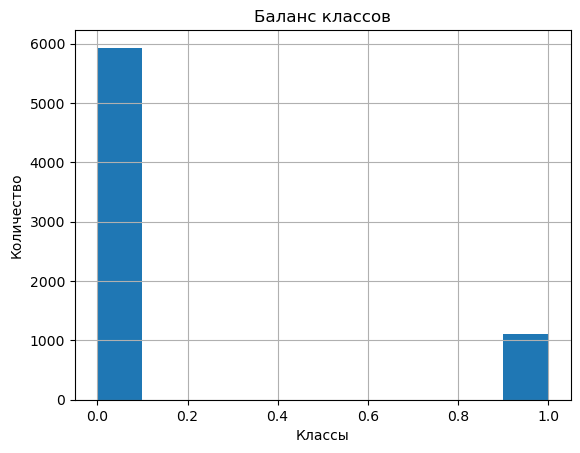

In [20]:
df['target'].hist(bins=10)
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Баланс классов')
plt.show()

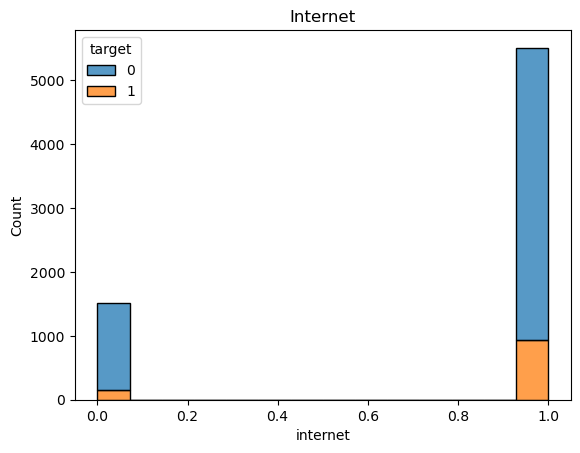

In [21]:
sns.histplot(df, x='internet', hue='target', multiple="stack")
plt.title('Internet')
plt.show()

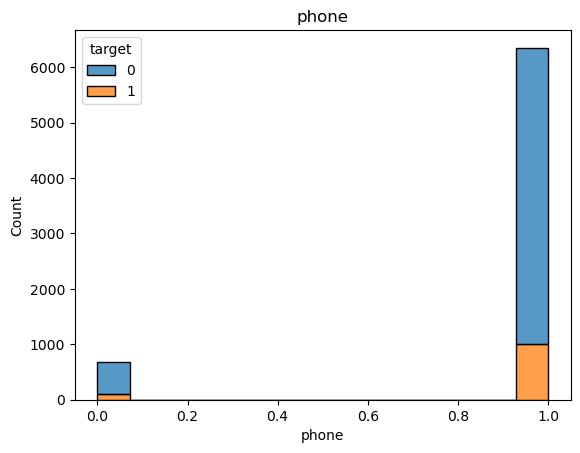

In [22]:
sns.histplot(df, x='phone', hue='target', multiple="stack")
plt.title('phone')
plt.show()

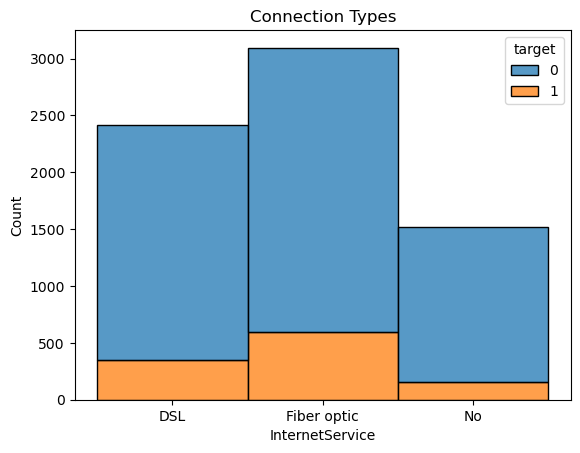

In [23]:
sns.histplot(df, x='InternetService', hue='target', multiple="stack")
plt.title('Connection Types')
plt.show()

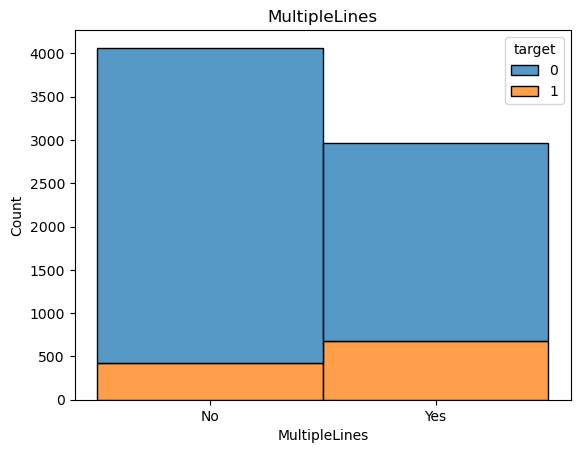

In [24]:
sns.histplot(df, x='MultipleLines', hue='target', multiple="stack")
plt.title('MultipleLines')
plt.show()

In [25]:
df = df.drop(['customerID'], axis=1)

In [26]:
df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'SeniorCitizen', 'internet', 'phone', 'period']


,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,period
BeginDate,1.000000,0.765275,0.078664,0.467586,0.421848,0.773731,0.461977,0.018540,0.049516,0.485513,...,0.414870,0.457995,0.468675,0.410714,0.369979,0.381092,0.131684,0.440017,0.034486,0.978241
Type,0.765275,1.000000,0.106151,0.277528,0.388557,0.470700,0.094622,0.000000,0.085800,0.179294,...,0.152239,0.099016,0.137817,0.180169,0.067123,0.070375,0.146149,0.065750,0.000000,0.635623
PaperlessBilling,0.078664,0.106151,1.000000,0.368945,0.467547,0.202168,0.082789,0.000000,0.241715,0.010489,...,0.000000,0.196937,0.161234,0.055354,0.344114,0.325351,0.481811,0.253299,0.017239,0.018839
PaymentMethod,0.467586,0.277528,0.368945,1.000000,0.398849,0.334563,0.214300,0.000000,0.291989,0.244661,...,0.261704,0.282245,0.306678,0.270893,0.377241,0.378375,0.533446,0.339987,0.000000,0.348275
MonthlyCharges,0.421848,0.388557,0.467547,0.398849,1.000000,0.711015,0.225823,0.005522,0.304546,0.204575,...,0.550855,0.629276,0.667621,0.576163,0.835680,0.833111,0.998682,0.676393,0.831671,0.387649
TotalCharges,0.773731,0.470700,0.202168,0.334563,0.711015,1.000000,0.303758,0.000000,0.136856,0.383135,...,0.522660,0.623588,0.642431,0.550988,0.642937,0.644346,0.548179,0.573224,0.159394,0.847572
target,0.461977,0.094622,0.082789,0.214300,0.225823,0.303758,1.000000,0.008800,0.085708,0.227597,...,0.132914,0.229736,0.218622,0.103933,0.200334,0.221756,0.113949,0.261345,0.000000,0.374101
gender,0.018540,0.000000,0.000000,0.000000,0.005522,0.000000,0.008800,1.000000,0.000000,0.000000,...,0.016788,0.007277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.049516,0.085800,0.241715,0.291989,0.304546,0.136856,0.085708,0.000000,1.000000,0.018075,...,0.056897,0.102206,0.090818,0.092485,0.163223,0.185621,0.281515,0.221386,0.000000,0.065128
Partner,0.485513,0.179294,0.010489,0.244661,0.204575,0.383135,0.227597,0.000000,0.018075,1.000000,...,0.222040,0.219762,0.237725,0.186312,0.192973,0.183090,0.000000,0.220874,0.021002,0.450246


**Промежуточный вывод:** Почти в 6 раз меньше клиентов ушли от оператора связи, чем остались, также большая часть клиентов пользовалась услугами связи. Большая часть клиентов из тех, которые пользуются интернетом предпочитают оптоволокно, скорее всего из-за высокой скорости передачи данных. Из тех же кто пользуется стационарной телефонной связью, большая часть не пользуется подключением к нескольким линиям, возможно из-за того, что это пригождается далеко не каждому. И такое распределение характерно как для ушедших, так и для оставшихся клиентов. Единственное, что отличается это среди ушедших клиентов большая часть пользовалась услугой MultipleLines. А по корреляции признаков видно, что присутствует очень сильная корреляция между BeginDate и period, что неудивительно так как от части period получился благодаря BeginDate. Также  присутствует крайне сильная корреляция между internet и MonthlyCharges.

## Обучение моделей

In [27]:
RANDOM_STATE = 140823

features = df.drop(['target', 'BeginDate'], axis=1)
target = df['target']
#разделяю выборку на train и test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [28]:
numeric = ['MonthlyCharges', 'period', 'TotalCharges']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [29]:
obj = ['Type', 'PaperlessBilling', 'PaymentMethod',
       'gender', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder.fit(features_train[obj])
features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[obj])
features_train = features_train.drop(['Type', 'PaperlessBilling', 'PaymentMethod',
       'gender', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'], axis=1)
features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[obj])
features_test = features_test.drop(['Type', 'PaperlessBilling', 'PaymentMethod',
       'gender', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'], axis=1)

### Случайный лес

In [30]:
%%time

model_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
parameters = {'min_samples_leaf': [i for i in range(1, 10, 4)],
              'max_depth': [i for i in range(1, 11, 4)],#использую class_weight для борьбы с дисбалансом
              'n_estimators': [i for i in range(1, 101, 20)]
             }

grid_forest = GridSearchCV(model_forest,
                         parameters,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)

grid_forest.fit(features_train, target_train)

print('Лучшие параметры:', grid_forest.best_params_)
print('Лучшее roc auc:', grid_forest.best_score_)

Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 41}
Лучшее roc auc: 0.8195776991676175
Wall time: 3.74 s


### LGBM

In [31]:
%%time

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
parameters = {'num_leaves': [i for i in range(10, 51, 10)],
              'max_depth': [i for i in range(1, 15, 2)],
              'n_estimators': [i for i in range(20, 100, 20)]
             }

grid_lgbm = GridSearchCV(model_lgbm,
                         parameters,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)

grid_lgbm.fit(features_train, target_train)
    

print('Лучшие параметры:', grid_lgbm.best_params_)
print('Лучшее roc auc:', grid_lgbm.best_score_)

Лучшие параметры: {'max_depth': 9, 'n_estimators': 80, 'num_leaves': 30}
Лучшее roc auc: 0.852605144231784
Wall time: 5.79 s


### CatBoost

In [32]:
%%time

model_cat = CatBoostClassifier(random_state=RANDOM_STATE)
parameters = {'depth': [i for i in range(1, 11, 2)],
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'iterations': [i for i in range(1, 101, 20)]
             }

grid_cat = GridSearchCV(model_lgbm,
                         parameters,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)

grid_cat.fit(features_train, target_train)
   

print('Лучшие параметры:', grid_cat.best_params_)
print('Лучшее roc auc:', grid_cat.best_score_)

Лучшие параметры: {'depth': 1, 'iterations': 1, 'learning_rate': 0.2}
Лучшее roc auc: 0.877338639093427
Wall time: 9.62 s


**Промежуточный вывод:** По результатам кросс валидации лучше всего себя показал CatBoost, но из-за лучших параметров мне кажется, что он переобучился, и лучше я возьму LGBM.

## Тестирование лучшей модели на тестовой выборке

In [33]:
model = LGBMClassifier(random_state=RANDOM_STATE, max_depth=9, n_estimators=80, num_leaves=30, class_weight='balanced')
model.fit(features_train, target_train)
roc_test = model.predict_proba(features_test)[:, 1]
print('Accuracy:', accuracy_score(target_test, model.predict(features_test)))
print('ROC-AUC:', roc_auc_score(target_test, roc_test))

Accuracy: 0.8054607508532423
ROC-AUC: 0.8648027575641516


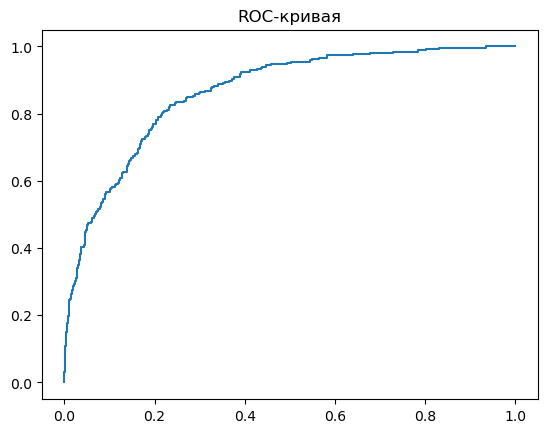

In [34]:
fpr, tpr, treshold = roc_curve(target_test, roc_test)
# строим график
plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.show()

**Вывод:** В итоге получилось достичь roc_auc равного 0,86, а значит задача выполнена.